In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Samples = 5000

df = pd.read_csv("C:/Users/ajadhav/Downloads/creditcardfraud/creditcard.csv")
df = df.sample(n=Samples)
df.drop('Time',axis=1,inplace=True)

In [102]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
281787,-2.589794,2.908523,-4.707253,-1.458683,1.375704,2.651158,-1.644597,3.300922,-0.670111,-1.179680,...,0.098886,-0.440960,0.476127,0.588655,-0.583937,0.216290,-0.601947,-0.059821,0.78,0
126440,-0.514211,0.301610,1.707260,-1.751879,-0.918394,0.512375,-1.501019,-2.254877,0.984165,-2.110888,...,-1.247478,0.515097,-0.219422,0.001588,1.347777,-0.663410,0.071597,0.164880,1.00,0
212043,0.177321,0.857276,0.372080,0.074329,0.491012,-0.963444,0.945709,-0.316010,-0.446075,-0.306729,...,-0.121191,-0.177379,0.144972,0.083927,-1.234396,0.205213,0.207318,0.240312,0.89,0
278628,-0.222575,1.154218,-0.791430,-0.674030,0.761759,-0.306402,0.548432,0.389629,-0.432458,-0.341927,...,0.426895,1.308296,-0.116721,0.319626,-0.717182,-0.243646,0.376758,0.252601,0.89,0
80502,1.292084,-1.263680,0.618125,-1.258050,-1.734644,-0.852623,-0.865935,-0.259925,-1.901476,1.334379,...,-0.291419,-0.687860,0.071759,0.372425,0.124689,-0.425343,0.028814,0.051029,122.38,0


In [103]:
Fraud = df[df['Class']==1]

Normal = df[df['Class']==0]

outliers_fraction = len(Fraud)/float(len(Normal))

In [104]:
columns = df.columns.tolist()
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["Class"]]
# Store the variable we are predicting 
target = "Class"
# Define a random state 
state = np.random.RandomState(42)
X = df[columns]
Y = df[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(5000, 29)
(5000,)


In [105]:
len(Normal)

4991

In [106]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X = pca.fit_transform(X)

In [107]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn import svm


classifiers = {
    "Support Vector Machine":svm.OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1, random_state=state)
   
}

In [108]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

n_outliers = len(Fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print(confusion_matrix(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))
    print('________________________________________________')

C:\Users\ajadhav\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\classes.py:1177: DeprecationWarning: The random_state parameter is deprecated and will be removed in version 0.22.
  " be removed in version 0.22.", DeprecationWarning)


Support Vector Machine: 421
Accuracy Score :
0.9158
[[4578  413]
 [   8    1]]
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      4991
           1       0.00      0.11      0.00         9

   micro avg       0.92      0.92      0.92      5000
   macro avg       0.50      0.51      0.48      5000
weighted avg       1.00      0.92      0.95      5000

________________________________________________


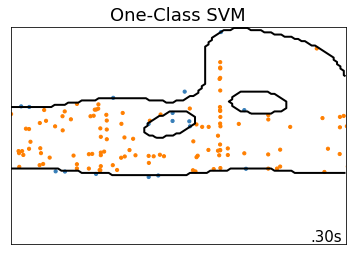

In [109]:
from sklearn.covariance import EllipticEnvelope


anomaly_algorithms = [
    ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf",
                                      gamma=0.1))]

plot_num = 1
iterations = 1
rng = np.random.RandomState(42)
import time


for name, algorithm in anomaly_algorithms:
    t0 = time.time()
    algorithm.fit(X)
    t1 = time.time()
    plt.subplot(iterations, len(anomaly_algorithms), plot_num)
    if i == 0:
        plt.title(name, size=18)

    # fit the data and tag outliers
    if name == "Local Outlier Factor":
        y_pred = algorithm.fit_predict(X)
    else:
        y_pred = algorithm.fit(X).predict(X)

    # plot the levels lines and the points
    if name != "Local Outlier Factor":  # LOF does not implement predict
        Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')

    colors = np.array(['#377eb8', '#ff7f00'])
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])

    plt.xlim(-7, 7)
    plt.ylim(-7, 7)
    plt.xticks(())
    plt.yticks(())
    plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
             transform=plt.gca().transAxes, size=15,
             horizontalalignment='right')
    plot_num += 1

plt.show()